# Resumen metricas

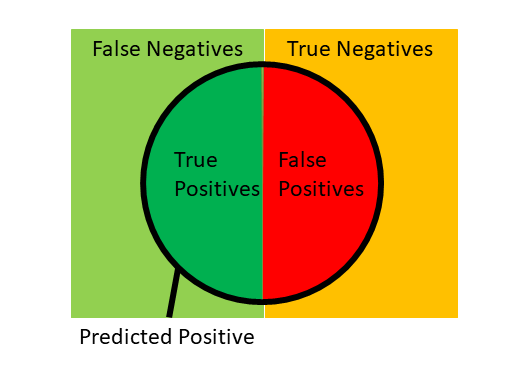
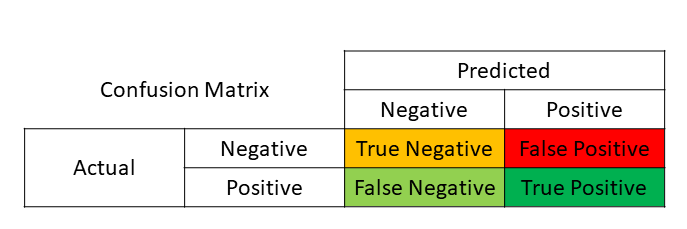
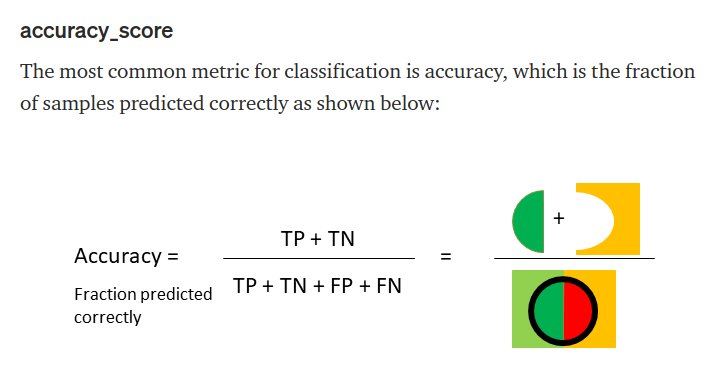
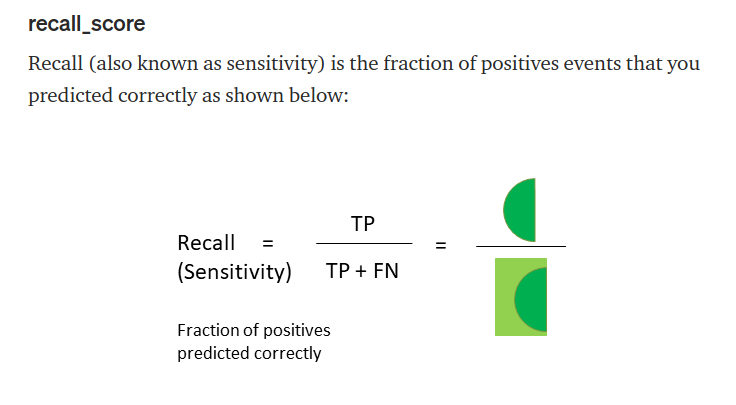
### falta el Kappa
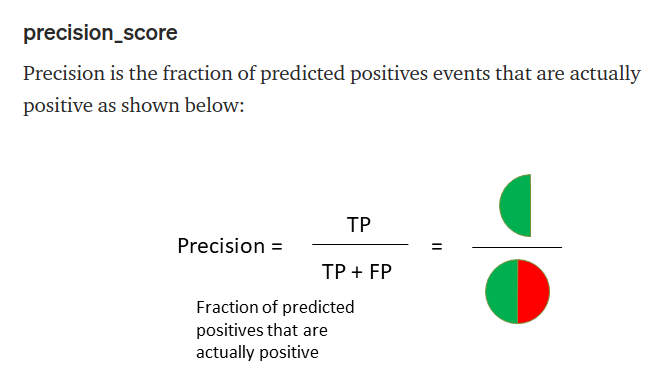
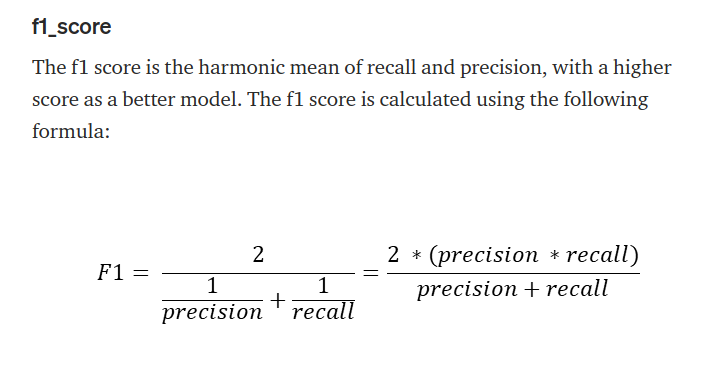
> [Fuente](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)


In [1]:
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

In [2]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/akima/.virtualenvs/mn/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.5.0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/akima/Documents/mn/repo/tp2
-- Configuring done
-- Generating do

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [8]:
def sRange(final, amount):
    for i in range(1, final, final//(amount-1)):
        yield i
    yield final

# Datos

In [4]:
df_train = pd.read_csv("../data/train.csv")
df_train = df_train[5000:10000] # Probando, borrar esta linea dsp

In [5]:
df_train["label"].value_counts(normalize=True)

1    0.1074
7    0.1066
3    0.1058
9    0.1034
2    0.1000
0    0.0994
4    0.0980
6    0.0974
8    0.0946
5    0.0874
Name: label, dtype: float64

# Dividir entre train y val

In [6]:
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

In [7]:
limit = int(0.6 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 3000 instancias de entrenamiento y 2000 de validación


# Correr con diferentes alpha y k

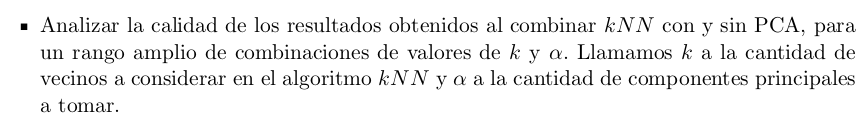

In [15]:
k_max, alpha_max = X_train.shape
alpha_max //= 4

alpha_amount = 50
k_amount = 50

print(f"alpha_max: {alpha_max}, k_max: {k_max}")

X_train_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

alpha_max: 196, k_max: 3000


In [13]:
pd.DataFrame(X_train_pca_max).to_csv(f"X_train_pca_{alpha_max}.csv")
pd.DataFrame(X_val_pca_max).to_csv(f"X_val_pca_{alpha_max}.csv")

In [ ]:
datos = []

for alpha in sRange(alpha_max, alpha_amount):
    if alpha_max/2 < alpha < (alpha_max/2)+alpha_amount:
            print("mitad de alpha")
            
    for k in sRange(k_max, k_amount):
        X_train_pca, X_val_pca = X_train_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_val_pca)

        acc = accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, average = 'weighted')
        precision = precision_score(y_val, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average = 'weighted')

        datos.append({'alpha': alpha, 'k':k, 'accuracy':acc, 'recall':recall, 'precision':precision, 'kappa':kappa, 'f1':f1})

datosDF = pd.DataFrame(datos)

/home/akima/.virtualenvs/mn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Resultados

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred) # ejemplo para los ultimos y_val, y_pred

In [ ]:
datosIndexed =  datosDF.set_index(['k', 'alpha']).unstack(level=0)

In [ ]:
datosIndexed['accuracy']

In [ ]:
datosIndexed.idxmax()
# datosIndexed['accuracy'].max().max()
datosIndexed.loc[1]['accuracy'][11]

In [ ]:
for metric in ['accuracy', 'recall', 'precision', 'kappa', 'f1']:
    sns.heatmap(datosIndexed[metric], annot = True).invert_yaxis()
    plt.title(metric)
    plt.show()

# Variando tamaño de entrenamiento

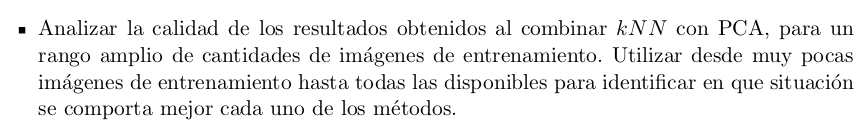

In [ ]:
alpha = 70
k = 6

pca= metnum.PCA(alpha)
clf = metnum.KNNClassifier(k)

datos = []
for portion in np.arange(0.1, 1, 0.1):
    limit = int(portion * X.shape[0]) 

    X_train, y_train = X[:limit], y[:limit]
    X_val, y_val = X[limit:], y[limit:]

    print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")
    
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)

    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average = 'weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average = 'weighted')

    datos.append({'train_portion': round(portion, 2), 'accuracy':acc, 'recall':recall, 'precision':precision, 'kappa':kappa, 'f1':f1})
            
datosExp2DF = pd.DataFrame(datos)

In [ ]:
datosExp2DFIndex = datosExp2DF.set_index('portion')
datosExp2DFIndex

# Relación de K con el conjunto de entrenamiento 

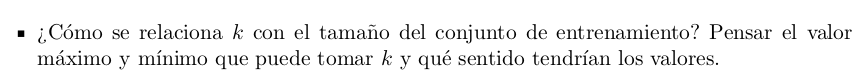
> k puede ser a lo sumo igual al tamaño del conjunto de entrenamiento, puesto que es la cantidad de vecinos contra la cuál comparamos al intentar encontrar una predicción. Como mínimo debo comparar contra uno. Por ende $k\in[1,\#conj]$

# Métricas sobre un conjunto bien balanceado

In [ ]:
df_train = pd.read_csv("../data/train.csv")